<b>Contributors to the team chances<b>

Football seems to be a simple game - scoring one more goal than opponent can not be that hard, right? 
For some teams though it is. And often the reason why this situation happens is ambiguous. One could say that providing forward 
for the team should solve a problem - but it does not need to. What if the key to good offensive team results lays somewhere 
else?


Team effort, which aims to score a goal, in majority of cases starts in the defense, then the ball is transported to the midfielders and after that provided to the attackers. Of course, this chain of events does not exist when the ball is intercepted by midfielders / attackers or team launches fast attack by directly moving ball from defenders to attackers. 
What does not change is the fact that in most situations defense or midfield of the team is involved in creation of chances for team.


The main point of the whole analysis is to find out whether there is a relationship between chances for scoring the goal 
(measured by expected goals indicator (xG)) and some statistics that describe team quality in defense and midfield
(for example short and medium pass completion percentage, tackles and touches in defensive or middle third or progressive passes) by creating several different models.


In [544]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import copy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV, KFold
import warnings
warnings.filterwarnings('ignore')

Data was scraped from football statistics site fbref.com, where detailed data regarding topic of analysis are provided over the course of last 6 seasons (starting at 2017/2018 season) from various leagues. For comparing and detecting differences in character of two top European leagues I selected German Bundesliga and English Premier League.

In [545]:
bundesliga_urls = ["https://fbref.com/en/comps/20/" + str(year) + "-" + str(year + 1) + "/" + 
        str(year) + "-" + str(year + 1) + "-Bundesliga-Stats" for year in range(2017, 2023)]
pl_urls = ["https://fbref.com/en/comps/9/" + str(year) + "-" + str(year + 1) + "/" + 
        str(year) + "-" + str(year + 1) + "-Premier-League-Stats" for year in range(2017, 2023)]

Every season's stats contains massive amount of rates which sumarize season for the given team. For the sake of analysis, I chose a few statistics that mainly relate to defensor's and midfielder's aspects of play. Division of football pitch into three separate parts (called thirds) enables to analyze statistics as events that happen in this specific sector, for example tackles and touches that are made by defenders and midfielders in the defensive stage of play (in the first third) and midfielders (in the second third). I also chose possession, average age (as starting point of analysis) and percentages of pass completion and data on progressive play and passes.

In [546]:
table_indexes = {
                  0: ['Rk', 'Squad', 'xG'],
                  2: [['Unnamed: 0_level_0', 'Squad'], ['Unnamed: 2_level_0', 'Age'], ['Unnamed: 3_level_0', 'Poss']], 
                 10: [['Short', 'Cmp%'], ['Medium', 'Cmp%'], ['Unnamed: 25_level_0', 'PrgP']],
                 16: [['Tackles', 'TklW'], ['Tackles', 'Def 3rd'], ['Tackles', 'Mid 3rd'], ['Challenges', 'Tkl%'],
                     ['Unnamed: 15_level_0', 'Int']],   
                 18: [['Touches', 'Touches'], ['Touches', 'Def 3rd'], ['Touches', 'Mid 3rd'], ['Carries', 'PrgDist'],
                     ['Carries', 'PrgC'], ['Receiving', 'PrgR']]}

Here I defined function that let me pass some dataset specifications and then get ready dataset. Function combines all needed information from various tables and adds data about season final classification.

In [547]:
def scrape_and_prepare_data(urls, table_indexes, starting_year):
    profiled_dict = {}
    rank_dict = {}
    profiled_list = []
    year = starting_year
    for url in urls:
        df = pd.read_html(url)
        for (sheet, cols_indexes) in table_indexes.items():
            if sheet != 0:
                for column in cols_indexes:
                    if column[0] == 'Short' or column[0] == 'Medium' or column[1] == 'Def 3rd' or column[1] == 'Mid 3rd':
                        profiled_dict[column[0] + " " + column[1]] = df[sheet][column[0],  column[1]]
                    else:
                        profiled_dict[column[1]] = df[sheet][column[0],  column[1]]
            else:
                for column in cols_indexes:
                    rank_dict[column] = df[sheet][column]
        rank_dict['Year'] = year
        profiled_dict['Year'] = year
        if year == starting_year:
            profiled_df = pd.DataFrame(profiled_dict)
            rank_df = pd.DataFrame(rank_dict)
            profiled_df = profiled_df.merge(rank_df, how='inner', on='Squad', suffixes=('', '_y')).drop("Year_y", axis=1)
        else:
            prof_df = pd.DataFrame(profiled_dict)
            rank_df = pd.DataFrame(rank_dict)
            prof_df = prof_df.merge(rank_df, how='inner', on=['Squad', 'Year'], suffixes=('', '_y'))
            profiled_df = pd.concat([profiled_df, prof_df])
        year += 1
    profiled_df.reset_index(drop=True, inplace=True)
    return profiled_df

I use it to create two datasets.

In [548]:
bundesliga_df = scrape_and_prepare_data(bundesliga_urls, table_indexes, 2018)

In [549]:
pl_df = scrape_and_prepare_data(pl_urls, table_indexes, 2018)

In [550]:
bundesliga_df.head()

,Squad,Age,Poss,Short Cmp%,Medium Cmp%,PrgP,TklW,Tackles Def 3rd,Tackles Mid 3rd,Tkl%,Int,Touches,Touches Def 3rd,Touches Mid 3rd,PrgDist,PrgC,PrgR,Year,Rk,xG
0,Augsburg,26.6,45.7,81.7,78.0,1117,543,361,292,60.4,400,18129,6243,7905,25463,524,1103,2018,12,44.7
1,Bayern Munich,27.4,66.1,90.7,89.7,2333,467,269,248,56.1,355,27289,6537,13304,42070,755,2314,2018,1,75.8
2,Dortmund,25.9,59.1,88.2,86.5,1712,510,305,307,57.5,336,24162,5898,12785,39596,733,1698,2018,4,66.0
3,Eint Frankfurt,26.4,47.9,82.4,81.5,1292,483,271,295,53.4,409,19250,5920,9658,26283,492,1278,2018,8,42.2
4,Freiburg,24.8,44.8,81.1,82.7,1061,465,300,289,51.5,392,18561,6830,8285,22979,399,1053,2018,15,39.6


In [551]:
pl_df.head()

,Squad,Age,Poss,Short Cmp%,Medium Cmp%,PrgP,TklW,Tackles Def 3rd,Tackles Mid 3rd,Tkl%,Int,Touches,Touches Def 3rd,Touches Mid 3rd,PrgDist,PrgC,PrgR,Year,Rk,xG
0,Arsenal,26.8,61.4,89.4,87.5,2223,425,312,227,37.5,427,29146,7494,13560,50346,915,2210,2018,6,68.3
1,Bournemouth,26.9,48.1,82.3,81.9,1526,324,272,187,37.7,367,22240,7636,9472,33018,702,1505,2018,12,38.8
2,Brighton,27.5,43.7,83.3,79.8,1230,380,360,205,31.9,449,20478,7473,8781,29182,523,1216,2018,15,37.0
3,Burnley,27.5,43.7,82.0,76.9,1103,355,272,217,36.9,400,19452,6334,8960,22260,431,1090,2018,7,32.3
4,Chelsea,26.7,55.6,89.5,87.0,1998,426,321,251,37.8,424,27165,8084,12055,51657,1045,1969,2018,5,54.4


In [552]:
bundesliga_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Squad            108 non-null    object 
 1   Age              108 non-null    float64
 2   Poss             108 non-null    float64
 3   Short Cmp%       108 non-null    float64
 4   Medium Cmp%      108 non-null    float64
 5   PrgP             108 non-null    int64  
 6   TklW             108 non-null    int64  
 7   Tackles Def 3rd  108 non-null    int64  
 8   Tackles Mid 3rd  108 non-null    int64  
 9   Tkl%             108 non-null    float64
 10  Int              108 non-null    int64  
 11  Touches          108 non-null    int64  
 12  Touches Def 3rd  108 non-null    int64  
 13  Touches Mid 3rd  108 non-null    int64  
 14  PrgDist          108 non-null    int64  
 15  PrgC             108 non-null    int64  
 16  PrgR             108 non-null    int64  
 17  Year            

In [553]:
pl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Squad            120 non-null    object 
 1   Age              120 non-null    float64
 2   Poss             120 non-null    float64
 3   Short Cmp%       120 non-null    float64
 4   Medium Cmp%      120 non-null    float64
 5   PrgP             120 non-null    int64  
 6   TklW             120 non-null    int64  
 7   Tackles Def 3rd  120 non-null    int64  
 8   Tackles Mid 3rd  120 non-null    int64  
 9   Tkl%             120 non-null    float64
 10  Int              120 non-null    int64  
 11  Touches          120 non-null    int64  
 12  Touches Def 3rd  120 non-null    int64  
 13  Touches Mid 3rd  120 non-null    int64  
 14  PrgDist          120 non-null    int64  
 15  PrgC             120 non-null    int64  
 16  PrgR             120 non-null    int64  
 17  Year            

We have the same amount of variables but different amount of rows, despite the fact we have the same year range. The reason is that there are 20 teams playing in Premier League while only 18 in Bundesliga.

What is great - we have 0 NA values, datasets are absolutely complete. It will be great advantage during Machine Learning modelling where diminishing training or test set will not be necessary.

First step will be to determine final type of problem - xG is numeric field, but I would like to work on classification. Let's then change it to categorical variable - with two levels: "higher" and "lower".

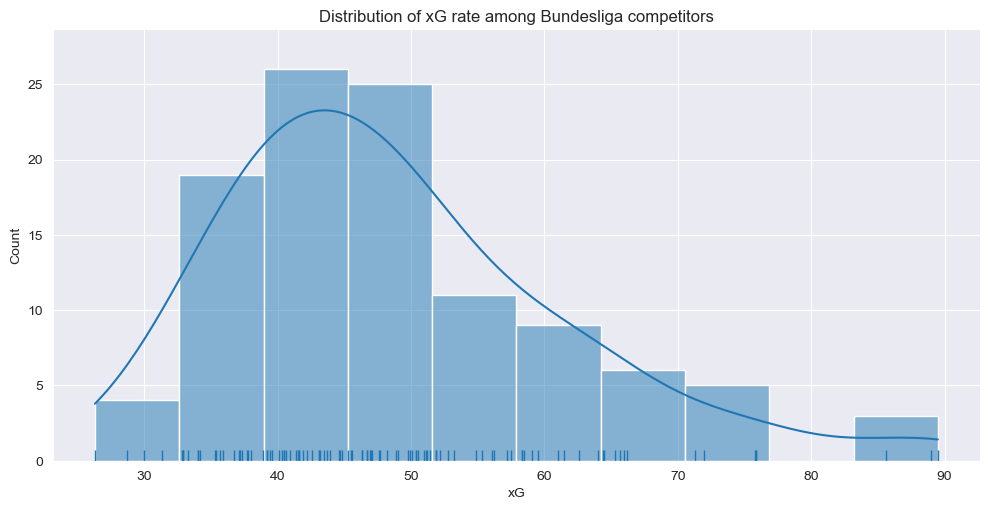

In [554]:
ax = sns.displot(bundesliga_df["xG"], aspect=2, kde=True, rug=True)
ax.set(xlabel='xG', ylabel='Count', title='Distribution of xG rate among Bundesliga competitors')
plt.show()

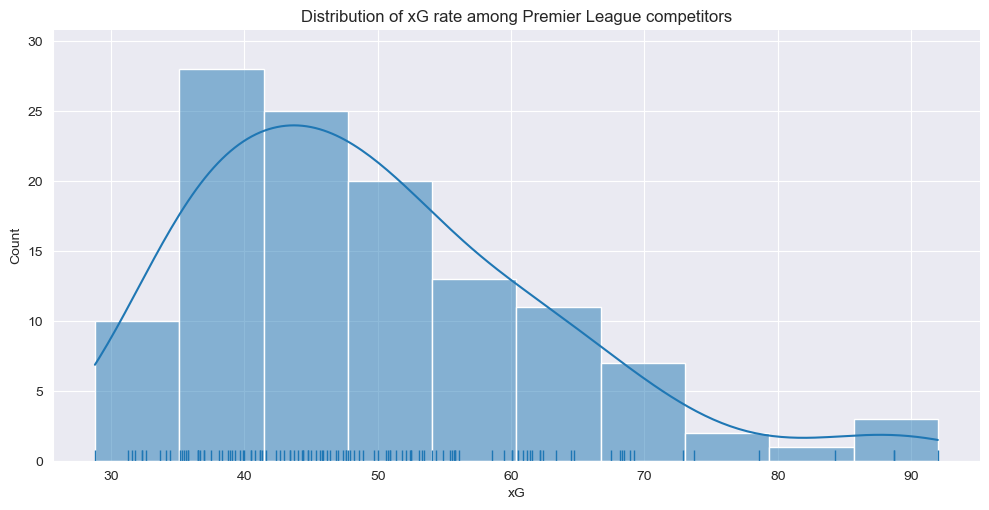

In [555]:
ax = sns.displot(pl_df["xG"], aspect=2, kde=True, rug=True)
ax.set(xlabel='xG', ylabel='Count', title='Distribution of xG rate among Premier League competitors')
plt.show()

Distributions of xG in both cases suggest a lack of normal distribution. I calculate the threshold - numerical boundaries for 
switching decision - as median of the variable which is later used in define_xG_level function.

In [556]:
def define_xG_level(x, threshold):
    if x >= threshold:
        return "higher"
    else:
        return "lower"

In [557]:
threshold = bundesliga_df["xG"].median()
bundesliga_df["xG_level"] = bundesliga_df["xG"].apply(define_xG_level, args=(threshold, ))

In [558]:
threshold = pl_df["xG"].median()
pl_df["xG_level"] = pl_df["xG"].apply(define_xG_level, args=(threshold, ))

Another variable that is in its current state not really useful is position in the league table after the end of the season. We have 1-18 or 1-20 different levels of states that are not comfortable to work with. I propose decreasing their number by specifying 4 new categories:
1. 'CL' - Champions League teams that are qualified to it or almost did it, top teams in the league
2. 'EL' - Europe League teams that are qualified to it or are relatively close to it, teams to the middle of table
3. 'MID - couple of middle table teams that are neither with the realistic chance of qualifying to Europe nor in danger of relegation
4. 'REL' - teams that were relegated or are in direct contact with relegation zone

In [559]:
def give_category(x, league_size):
    if x >= 1 and x <= 5:
        return 'CL'
    if x > 5 and x <= 10:
        return 'EL'
    if x > 10 and x <= 14:
        return 'MID'
    if x > 14 and x <= league_size:
        return 'REL'

In [560]:
bundesliga_df['Rk_cat'] = bundesliga_df['Rk'].apply(give_category, args=(18,))
bundesliga_df.drop('Rk', axis=1)

,Squad,Age,Poss,Short Cmp%,Medium Cmp%,PrgP,TklW,Tackles Def 3rd,Tackles Mid 3rd,Tkl%,...,Touches,Touches Def 3rd,Touches Mid 3rd,PrgDist,PrgC,PrgR,Year,xG,xG_level,Rk_cat
0,Augsburg,26.6,45.7,81.7,78.0,1117,543,361,292,60.4,...,18129,6243,7905,25463,524,1103,2018,44.7,lower,MID
1,Bayern Munich,27.4,66.1,90.7,89.7,2333,467,269,248,56.1,...,27289,6537,13304,42070,755,2314,2018,75.8,higher,CL
2,Dortmund,25.9,59.1,88.2,86.5,1712,510,305,307,57.5,...,24162,5898,12785,39596,733,1698,2018,66.0,higher,CL
3,Eint Frankfurt,26.4,47.9,82.4,81.5,1292,483,271,295,53.4,...,19250,5920,9658,26283,492,1278,2018,42.2,lower,EL
4,Freiburg,24.8,44.8,81.1,82.7,1061,465,300,289,51.5,...,18561,6830,8285,22979,399,1053,2018,39.6,lower,REL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,Schalke 04,28.3,46.1,79.7,80.0,816,293,221,221,46.2,...,15254,5824,6243,17543,358,810,2023,34.0,lower,REL
104,Stuttgart,25.4,49.2,85.8,85.9,1092,292,230,196,51.7,...,18221,6642,7905,27387,545,1077,2023,40.5,lower,REL
105,Union Berlin,28.6,42.9,82.3,80.3,855,254,199,198,46.4,...,15675,5915,6336,18767,319,838,2023,32.8,lower,CL
106,Werder Bremen,28.1,50.3,84.2,82.6,1030,313,229,248,50.0,...,18342,6378,8512,22798,372,1023,2023,37.1,lower,MID


In [561]:
pl_df['Rk_cat'] = pl_df['Rk'].apply(give_category, args=(20,))
pl_df.drop('Rk', axis=1)

,Squad,Age,Poss,Short Cmp%,Medium Cmp%,PrgP,TklW,Tackles Def 3rd,Tackles Mid 3rd,Tkl%,...,Touches,Touches Def 3rd,Touches Mid 3rd,PrgDist,PrgC,PrgR,Year,xG,xG_level,Rk_cat
0,Arsenal,26.8,61.4,89.4,87.5,2223,425,312,227,37.5,...,29146,7494,13560,50346,915,2210,2018,68.3,higher,EL
1,Bournemouth,26.9,48.1,82.3,81.9,1526,324,272,187,37.7,...,22240,7636,9472,33018,702,1505,2018,38.8,lower,MID
2,Brighton,27.5,43.7,83.3,79.8,1230,380,360,205,31.9,...,20478,7473,8781,29182,523,1216,2018,37.0,lower,REL
3,Burnley,27.5,43.7,82.0,76.9,1103,355,272,217,36.9,...,19452,6334,8960,22260,431,1090,2018,32.3,lower,EL
4,Chelsea,26.7,55.6,89.5,87.0,1998,426,321,251,37.8,...,27165,8084,12055,51657,1045,1969,2018,54.4,higher,CL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,Nott'ham Forest,27.3,38.7,81.9,79.9,796,342,324,183,51.4,...,16407,6726,6432,22192,405,785,2023,35.2,lower,REL
116,Southampton,25.3,44.8,86.1,82.4,1022,388,340,260,50.0,...,18968,6624,8091,26584,512,1009,2023,31.8,lower,REL
117,Tottenham,28.4,49.5,89.4,87.2,1317,322,287,193,48.6,...,21257,7678,9108,32724,628,1305,2023,50.9,higher,EL
118,West Ham,28.9,41.7,86.5,81.7,1100,293,258,199,48.9,...,17485,5979,7365,23750,532,1093,2023,43.7,lower,REL


We can now look at the distribution of certain categories of positions in table within xG levels. 

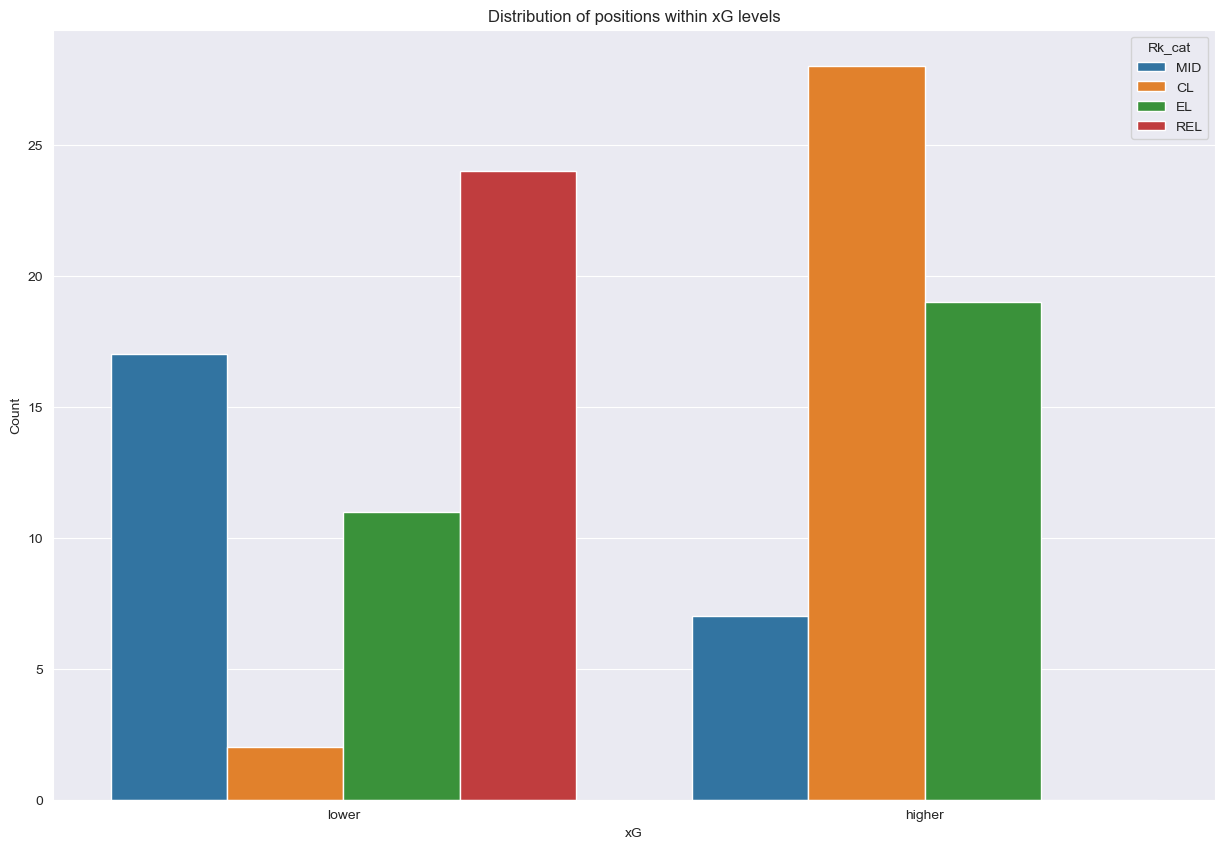

In [562]:
gr_b = bundesliga_df[["xG_level", "Rk_cat"]].groupby(["xG_level", "Rk_cat"]).value_counts()
plt.figure(figsize=(15,10))
ax = sns.countplot(data=bundesliga_df, x="xG_level", hue="Rk_cat")
ax.set(xlabel="xG", ylabel="Count", title="Distribution of positions within xG levels")
plt.show()

It is clearly visible that lower level of xG characterizes all of the teams from relegation zone, majority of teams from middle of the table, but what is curious also some teams from Europa League zone or even one leading power from one of the campaign.

Quick view on the 'Squad' variable let us acknowledge that thanks to higher variance, Bundesliga tends to let more teams in the league - in this aspect, Premier League is more exclusive.

In [563]:
bundesliga_df["Squad"].value_counts().var()

4.2266666666666675

In [564]:
pl_df["Squad"].value_counts().var()

3.980295566502462

Let's start with some look on the players age tendency over the course of 6 last seasons.

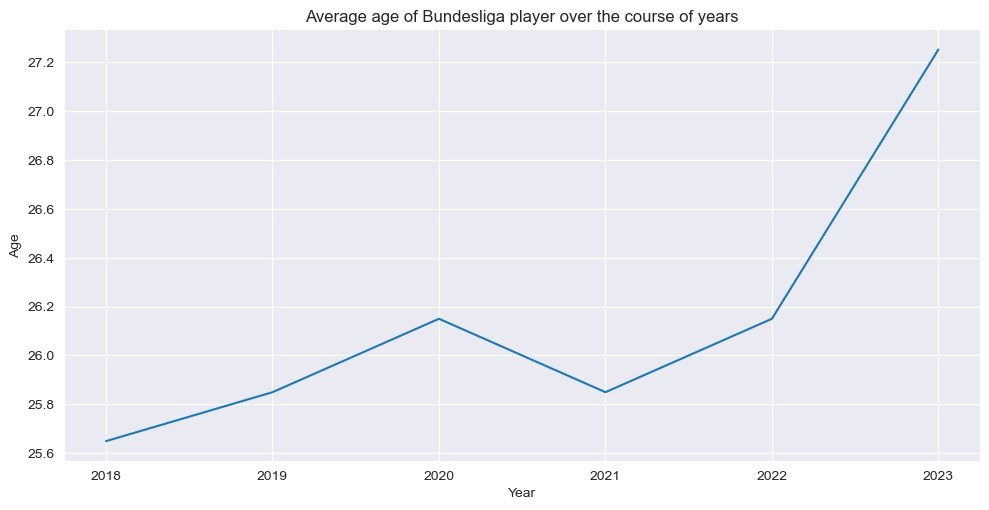

In [565]:
sns.set_style("darkgrid")
agg_age = bundesliga_df[["Year", "Age"]].groupby("Year").median()
ax = sns.relplot(x="Year", y="Age", data = agg_age, kind = "line", aspect=2)
ax.set(title="Average age of Bundesliga player over the course of years")
plt.show()

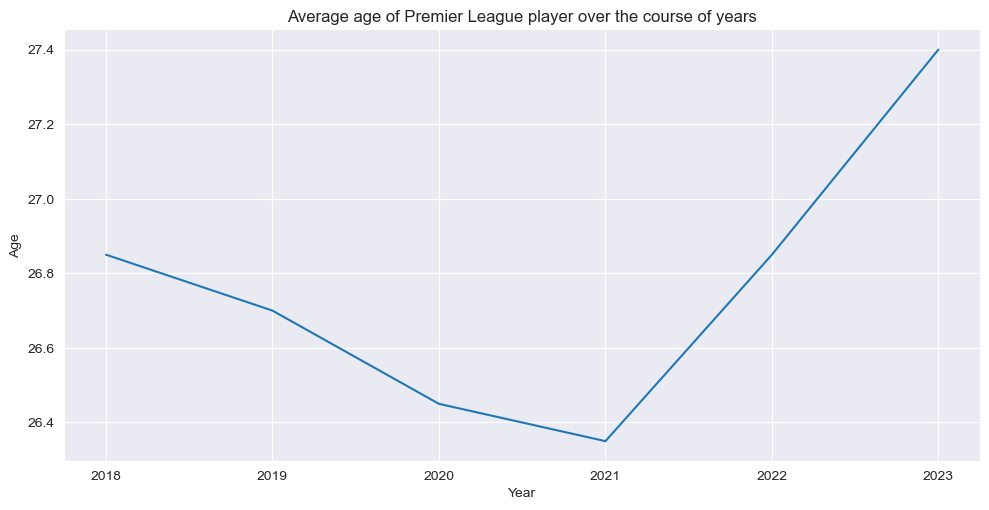

In [566]:
agg_age = pl_df[["Year", "Age"]].groupby("Year").median()
ax = sns.relplot(x="Year", y="Age", data = agg_age, kind = "line", aspect=2)
ax.set(title="Average age of Premier League player over the course of years")
plt.show()

It is at least interesting - both leagues note considerable increase in average age of squad since 2021. It is especially surprising in case of Bundesliga which is seen as leading talents-promoting competition.

Now let's look on something way more interesting - relationship between age and possession with another look on position in table categories.

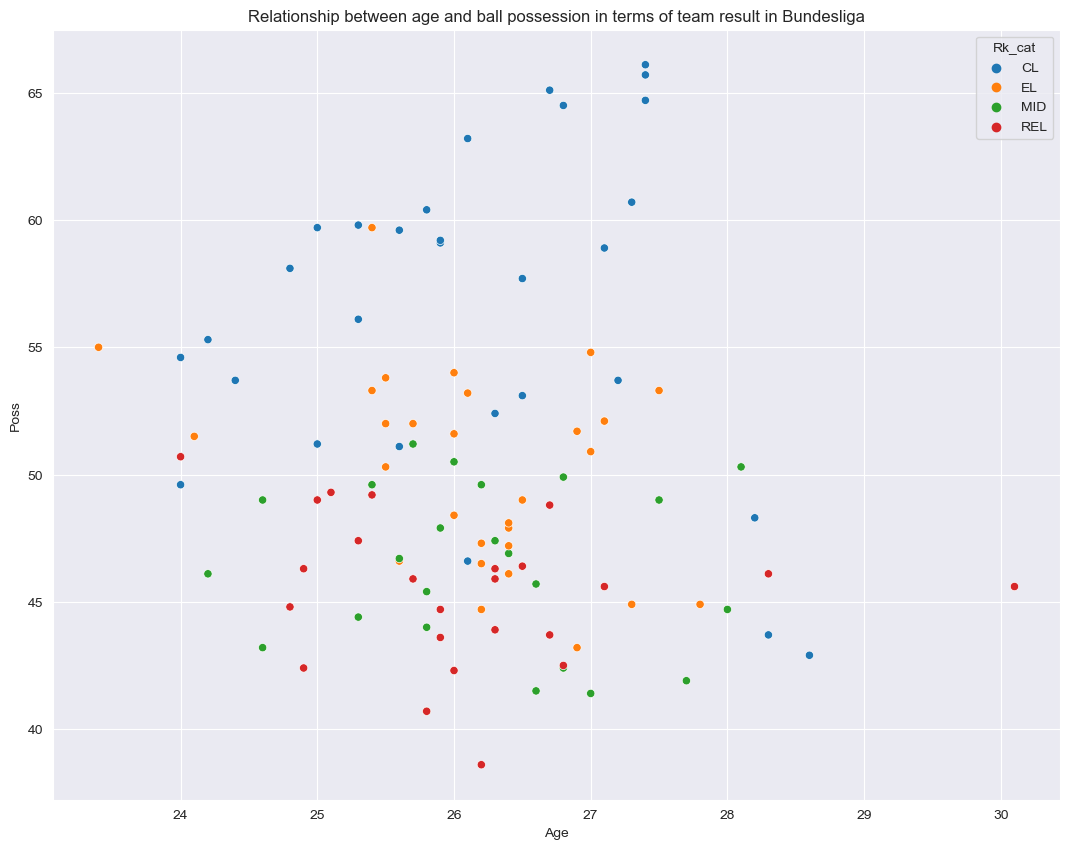

In [567]:
plt.figure(figsize=(13,10))
ax = sns.scatterplot(x='Age', y='Poss', data=bundesliga_df, hue='Rk_cat', hue_order = ['CL', 'EL', 'MID', 'REL'])
ax.set(title="Relationship between age and ball possession in terms of team result in Bundesliga")
plt.show()

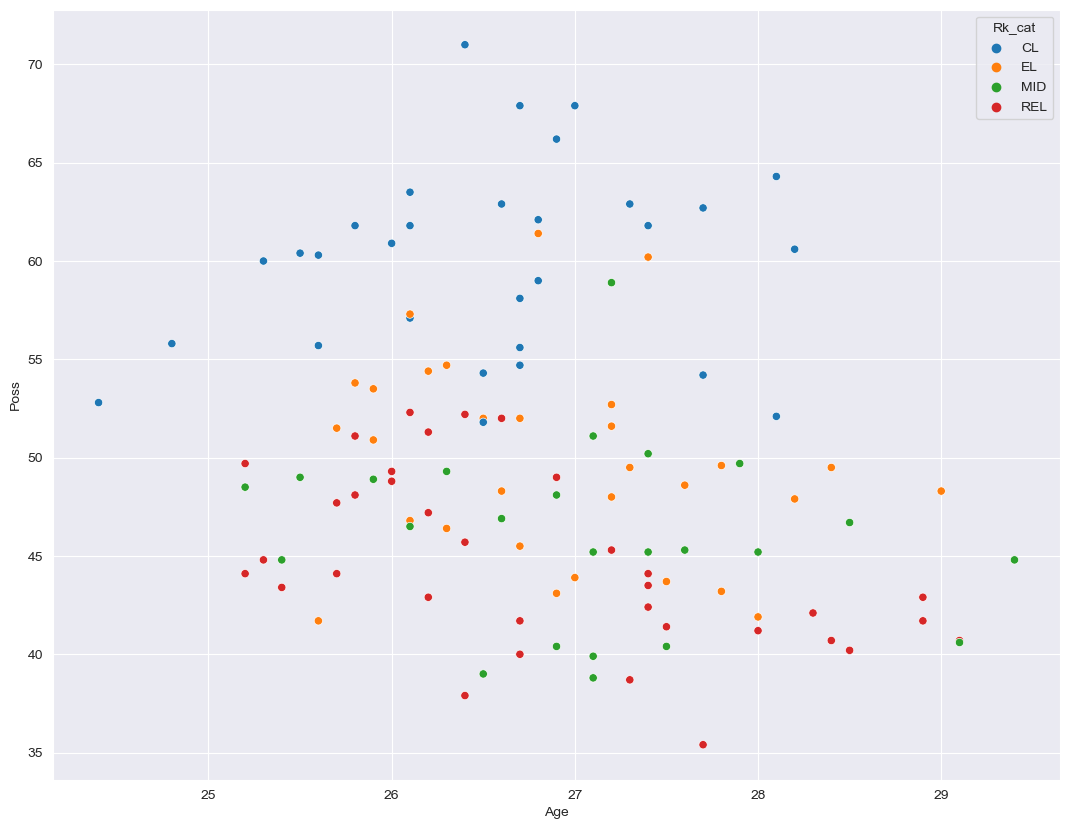

In [568]:
plt.figure(figsize=(13,10))
sns.scatterplot(x='Age', y='Poss', data=pl_df, hue='Rk_cat', hue_order = ['CL', 'EL', 'MID', 'REL'])
ax.set(title="Relationship between age and ball possession in terms of team result in Premier League")
plt.show()

While age is something apparently unrelated to ball possession and position in table, we see some trends in different place - all teams from relegation zone do not have much ball possession and also many best - in terms of final result - squads reach very high possesion.

Then, if best teams achieve high possession, they are very likely to have high xG rates.

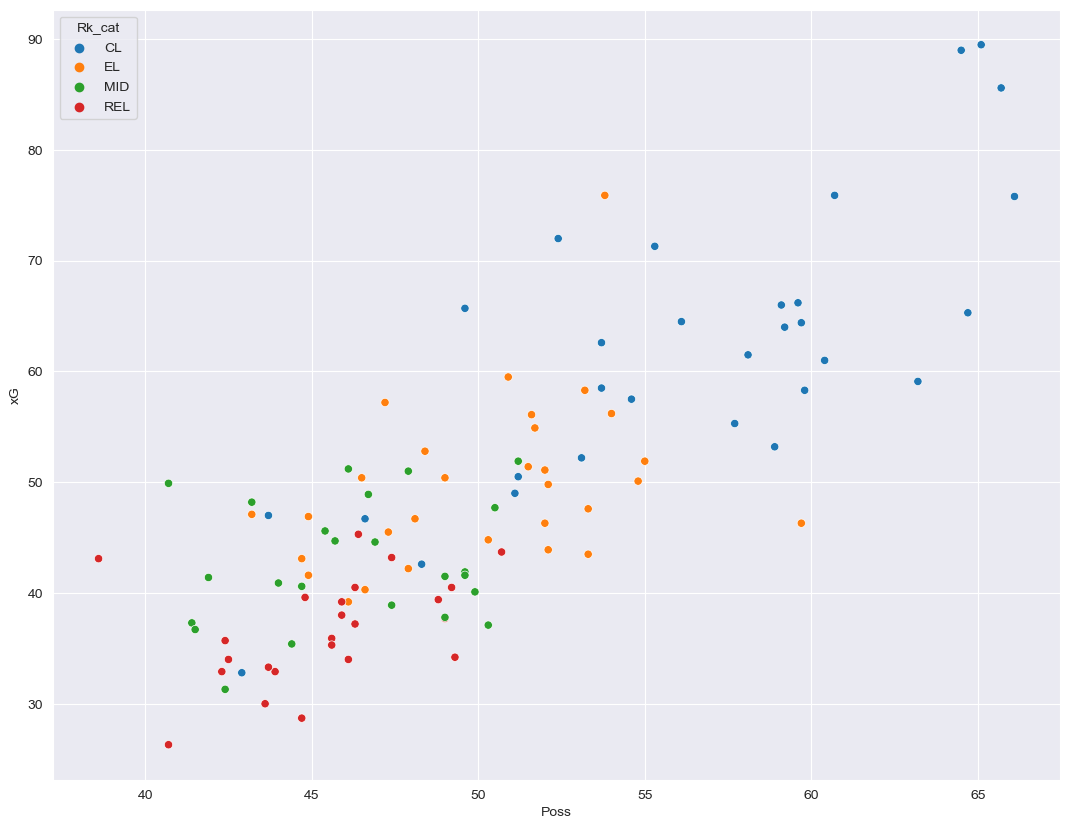

In [569]:
plt.figure(figsize=(13,10))
sns.scatterplot(x='Poss', y='xG', data=bundesliga_df, hue='Rk_cat', hue_order = ['CL', 'EL', 'MID', 'REL'])
ax.set(title="Relationship between ball possession and xG in terms of team result in Bundesliga")
plt.show()

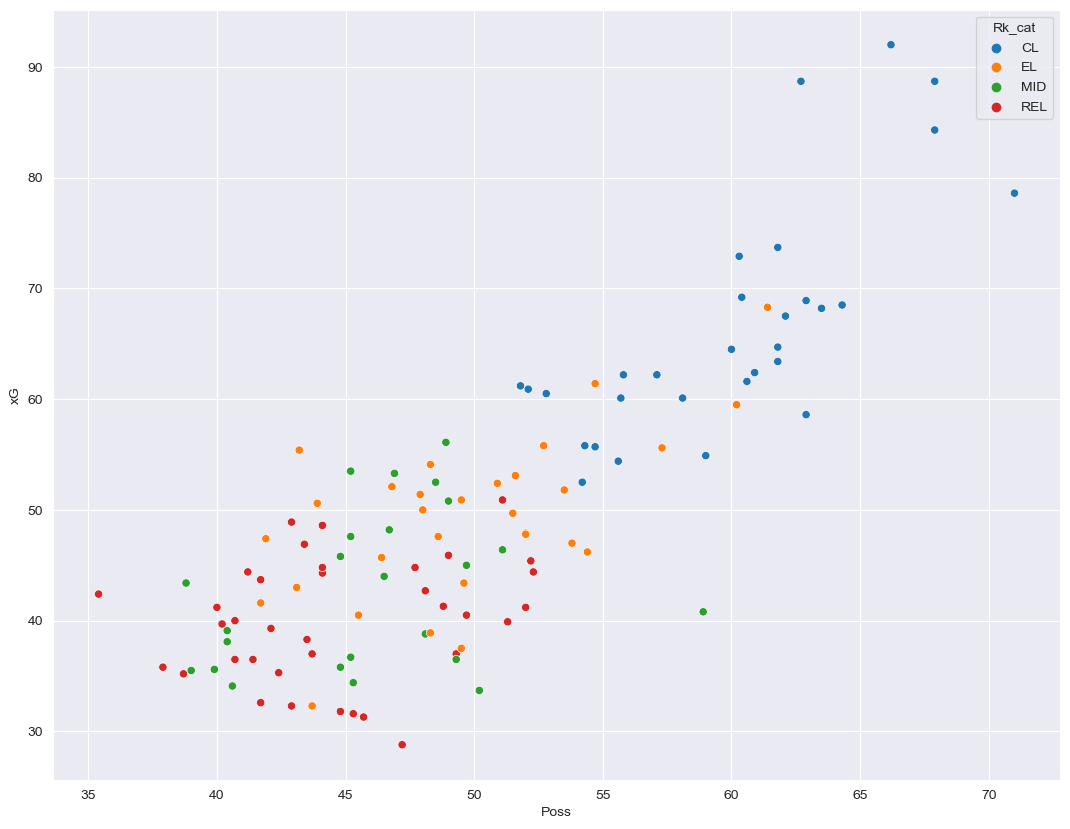

In [570]:
plt.figure(figsize=(13,10))
sns.scatterplot(x='Poss', y='xG', data=pl_df, hue='Rk_cat', hue_order = ['CL', 'EL', 'MID', 'REL'])
ax.set(title="Relationship between ball possession and xG in terms of team result in Bundesliga")
plt.show()

Relationships are linear and the thesis turned out to be true - the higher ball possession is, the higher xG rate will be.

Having this point stated, we can move on to the more detailed part.

Let's check how much xG rate will be affected by changing values of touches in middle third.

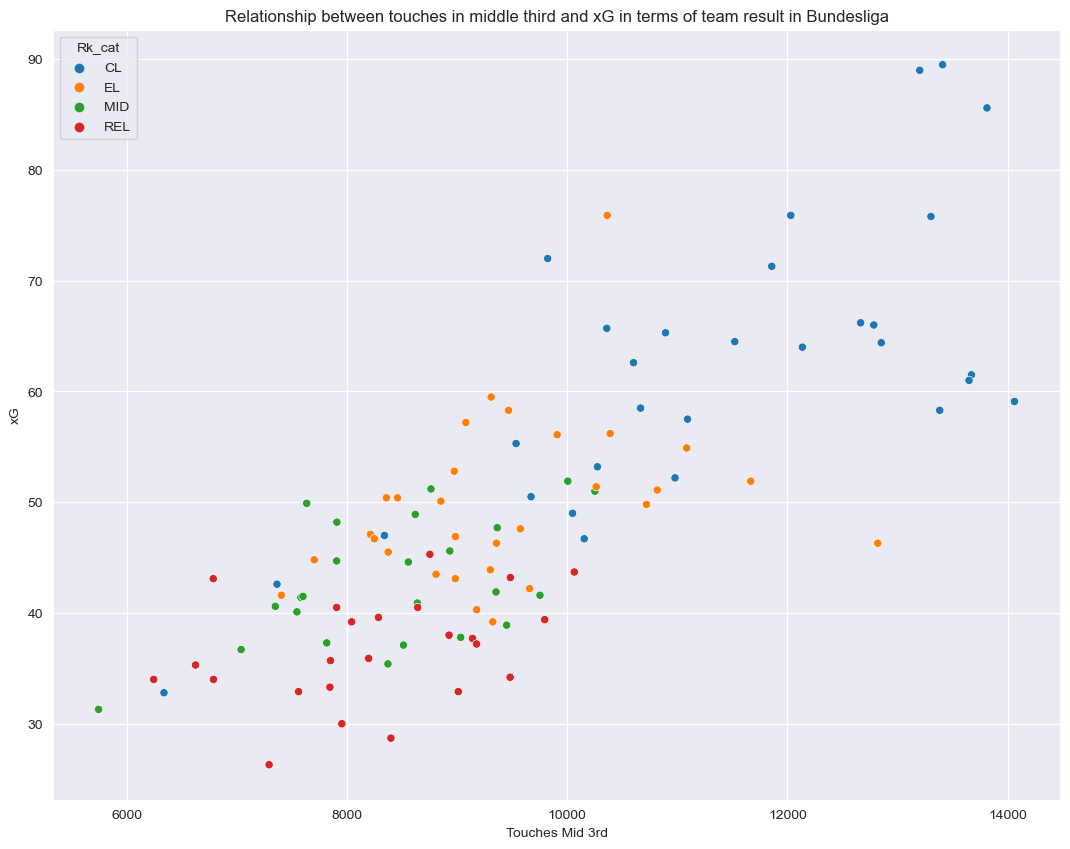

In [571]:
plt.figure(figsize=(13,10))
ax = sns.scatterplot(x='Touches Mid 3rd', y='xG', data=bundesliga_df, hue='Rk_cat', hue_order = ['CL', 'EL', 'MID', 'REL'])
ax.set(title="Relationship between touches in middle third and xG in terms of team result in Bundesliga")
plt.show()

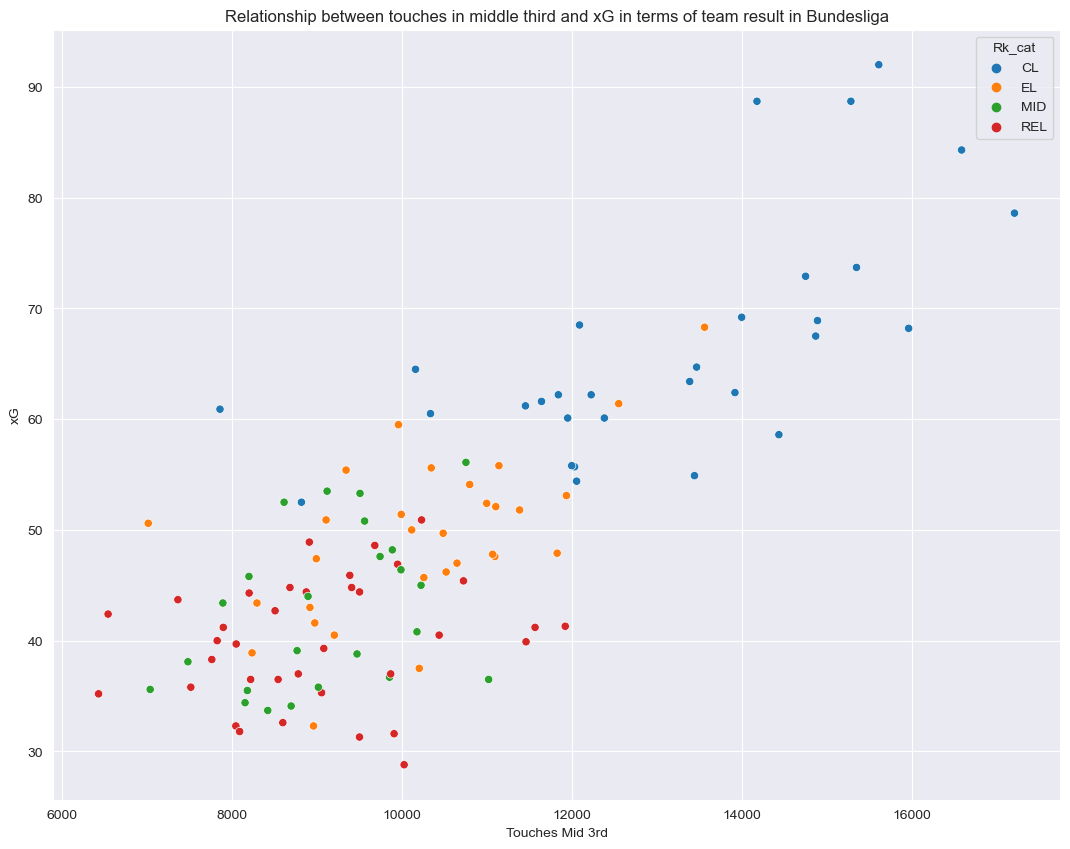

In [572]:
plt.figure(figsize=(13,10))
ax = sns.scatterplot(x='Touches Mid 3rd', y='xG', data=pl_df, hue='Rk_cat', hue_order = ['CL', 'EL', 'MID', 'REL'])
ax.set(title="Relationship between touches in middle third and xG in terms of team result in Bundesliga")
plt.show()

Plots look very similar to the previous relationship - xG is linearly connected with touches in the middle third because of the high correlation.

To avoid pointless plotting similar relationship, let's look on the correlation matrix.

In [573]:
to_drop_bef_cor = ["Squad", "Age", "Poss", "Rk", "Rk_cat", "Year"]
to_cor_bund = bundesliga_df.drop(to_drop_bef_cor, axis=1)
to_cor_pl = pl_df.drop(to_drop_bef_cor, axis=1)

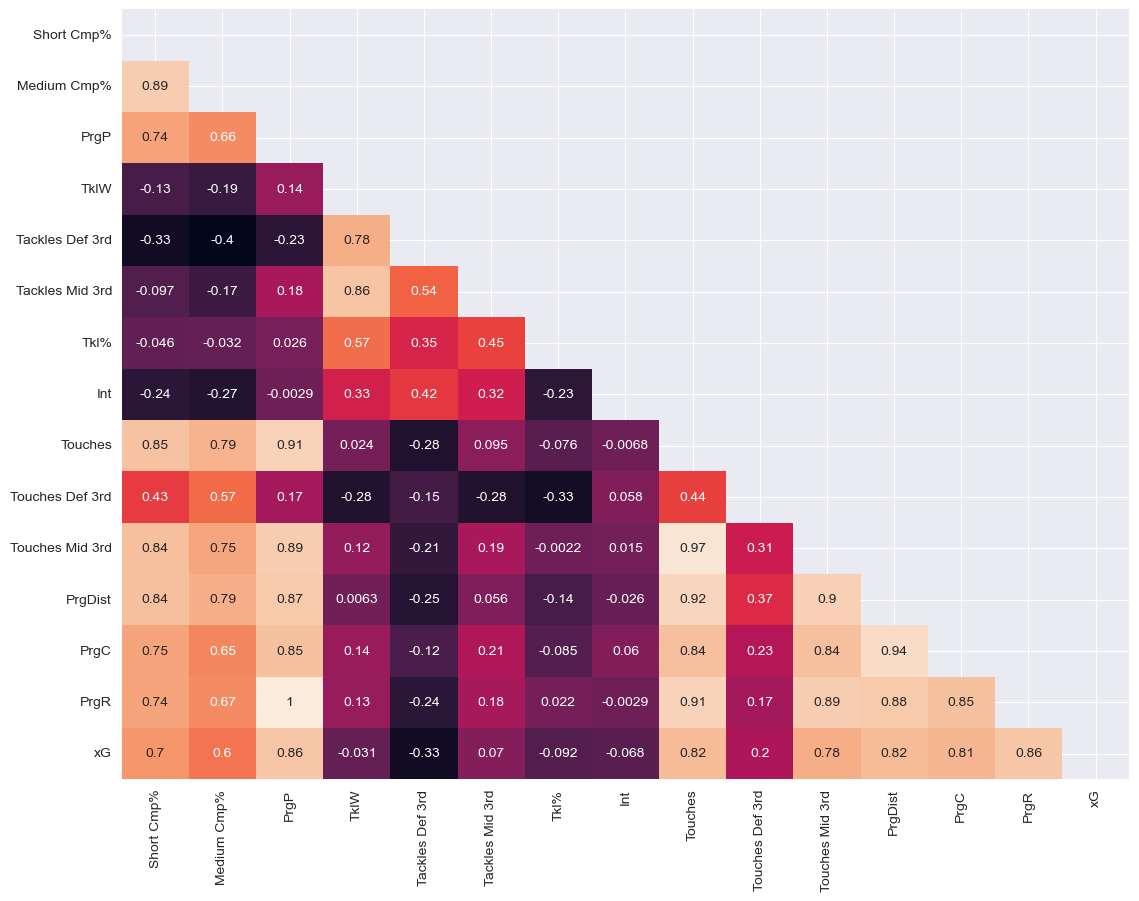

In [574]:
plt.figure(figsize=(13,10))
sns.heatmap(to_cor_bund.corr(), annot=True, mask=np.triu(to_cor_bund.corr()), cbar=False)
plt.show()

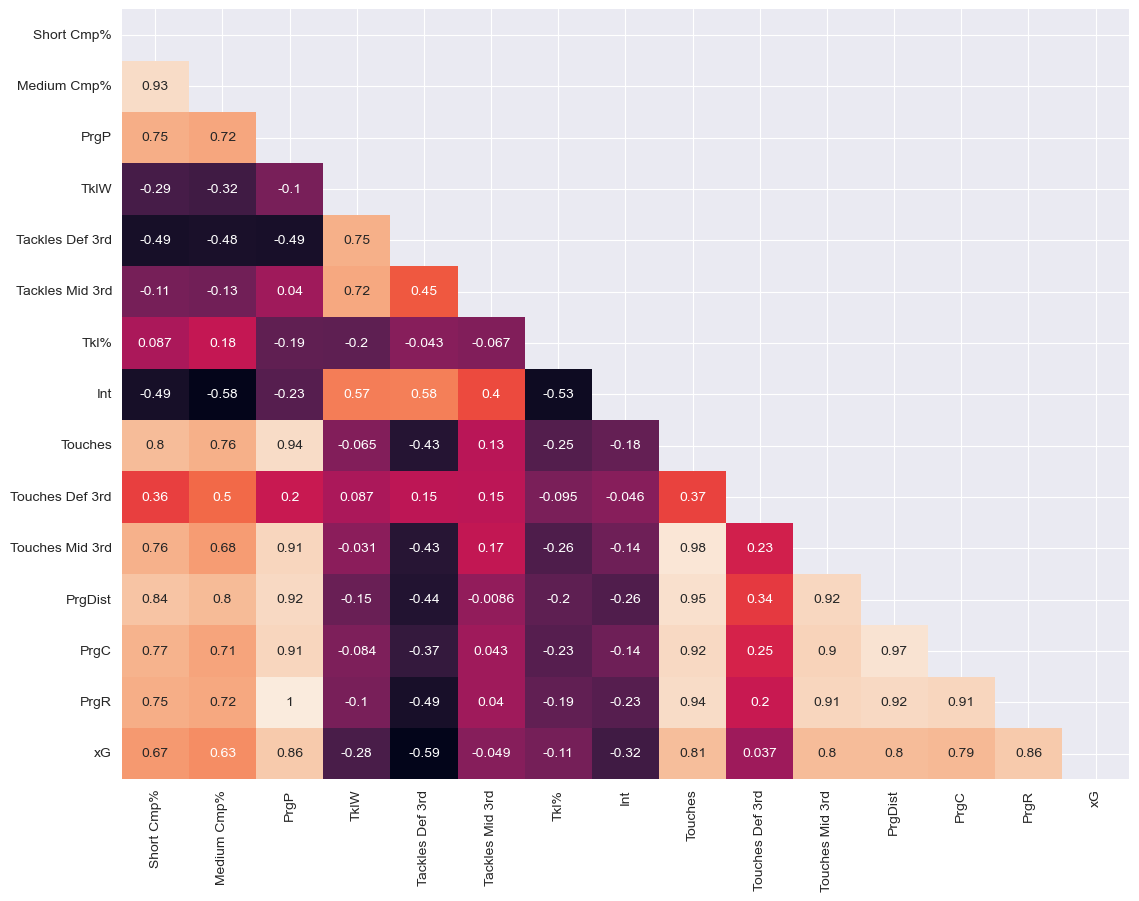

In [575]:
plt.figure(figsize=(13,10))
sns.heatmap(to_cor_pl.corr(), annot=True, mask=np.triu(to_cor_pl.corr()), cbar=False)
plt.show()

Analysis of the matrix correlation is one of the most important steps in the data preparation for modelling. We do not want to include too many features to complicate model, thus we will reject some features that are correlated with included ones:

1) Short and Medium Pass Completion Percentages are highly correlated, that's why I will select only Short Cpm%. 
2) Tackles in defensive third are negatively correlated on decent level, oppositely to those in middle third that barely show any sign of correlation.
3) Touches in middle third are highly correlated, but not only with xG, but also with Received Progressive Passes (PrgR) which are higher correlated with xG - I will take them.

Looking on the starting set of features, I have only 3 features, but I believe these selected ones are a good choice - they are not correlated with themselves on extreme level and most of all two of them represents events that primarily happen in the middle of the pitch and one that describes defensive feature.

With this set of features, I can go directly to modelling step

First, I prepare data.

In [576]:
data_for_ml_bundesliga = to_cor_bund[["Short Cmp%", "Tackles Def 3rd", "PrgR", "xG_level"]]
data_for_ml_pl = to_cor_pl[["Short Cmp%", "Tackles Def 3rd", "PrgR", "xG_level"]]

Then, I implement from scratch three basic supervised learning models: KNN and Naive Bayes classifiers (parametric with assumption of normal distribution and not parametric (with Parzen window parameter)).

In [577]:
class KNN:
    
    @staticmethod
    def distance(x, y, m):
        add = 0
        length = 0
        for i in range(len(x)):
            if (not isinstance(x[i], str)) and (not isinstance(x[i], bool)):
                length += 1
        for i in range(length):
            difference = abs(x[i] - y[i])
            power = 1
            for j in range(m):
                power *= difference
            add += power
        return add**(1/m)
    
    @staticmethod
    def execute(sample, dataset, m, k, label):
        index_d = 0
        for index, element in enumerate(dataset.columns):
            if element == label:
                index_d = index
        distances = []
        for i in range(len(dataset)):
            distance_s_from_d = KNN.distance(sample,dataset.loc[i],m)
            distances.append((dataset.loc[i][index_d], distance_s_from_d))
        distances.sort(key=lambda x: x[1])
        neighbours = []
        for i in range(k):
            neighbours.append(distances[i])
        results = []
        help = []
        counter_1 = 0
        counter_2 = 0
        basic_counter = 0
        while counter_1 < len(neighbours):
            counter_2 = counter_1 + 1
            candidate = neighbours[counter_1][0]
            if candidate not in help:
                    basic_counter += 1
            else:
                counter_1 += 1
                continue
            while counter_2 < len(neighbours) - counter_1:
                if neighbours[counter_2][0] == candidate:
                    basic_counter += 1
                counter_2 += 1
            help.append(candidate)
            results.append((candidate, basic_counter))
            basic_counter = 0
        results.sort(key=lambda x: x[1])
        if sample.iloc[index_d] == results[0][0]:
            return True
        else:
            return False
        
    @staticmethod
    def test(training_dataset, test_dataset, m, k, label):
        correct = 0
        for i in range(len(test_dataset)):
            result = KNN.execute(test_dataset.loc[i], training_dataset, m, k, label)
            if result:
                correct += 1
        return correct / len(test_dataset) * 100

In [578]:
class BayesNormal:
    @staticmethod
    def filtered_dataset(dataset, label_column, given_class):
        return dataset.loc[dataset[label_column] == given_class, :]
    
    @staticmethod
    def mean(dataset, column):
        return dataset[column].mean()
    
    @staticmethod
    def variance(dataset, column):
        return dataset[column].var()
    
    @staticmethod
    def normal_distribution(x, mean, var):
        return 1/(np.sqrt(2)*math.pi*np.sqrt(var))*math.e**(-((x-mean)**2)/(2*var))
    
    @staticmethod
    def execute(training_dataset, label_column, test_dataset):
        data_stats = {}
        classes_probs = {}
        points_probs = {}
        true_values = {}
        cond_probs = {}
        divide = {}
        for col_lab in training_dataset[label_column].unique():
            filtered = BayesNormal.filtered_dataset(training_dataset, label_column, col_lab)
            for feature in training_dataset.columns[:-1]:
                data_stats[col_lab+"_"+feature+"_"+"mean"] = BayesNormal.mean(filtered, feature)
                data_stats[col_lab+"_"+feature+"_"+"variance"] = BayesNormal.variance(filtered, feature)
            classes_probs[col_lab] = len(filtered) / len(training_dataset)
            
        for index, observation in test_dataset.iterrows():
            probs_for_features = {}
            for col_lab in test_dataset[label_column].unique():
                product = 1
                for feature in test_dataset.columns[:-1]:
                    product *= BayesNormal.normal_distribution(observation[feature],
                                                                         data_stats[col_lab+"_"+feature+"_"+"mean"], 
                                                                      data_stats[col_lab+"_"+feature+"_"+"variance"])
                probs_for_features[col_lab] = product
            true_values[index] = observation[label_column]
            points_probs[index] = probs_for_features
        probs_copy = copy.copy(points_probs)
        for (index, probs) in probs_copy.items():
            add = 0
            for (label, prob) in probs.items():
                add += classes_probs[label] * probs_copy[index][label]
            divide[index] = add
        for (index, probs) in probs_copy.items():
            for (label, prob) in probs.items():
                points_probs[index][label] = classes_probs[label] * probs_copy[index][label] / divide[index]
        new = {}
        for (index, probs) in probs_copy.items():
            new[index] = {k: v for k, v in sorted(probs.items(), key=lambda item: item[1], reverse=True)}
        results = {}
        for (index, probs) in probs_copy.items():
            results[index] = max(probs, key=probs.get)
        correct = 0
        for (index, chosen) in results.items():
            if (chosen == true_values[index]):
                correct += 1
        return correct / len(test_dataset)*100

In [579]:
class BayesParzen:
    @staticmethod
    def filtered_dataset(dataset, label_column, given_class):
        return dataset.loc[dataset[label_column] == given_class, :]
    
    @staticmethod
    def gaussian_kernel(x):
        return 1/np.sqrt(2*math.pi)*math.e**(-1/2*x**2)
    
    @staticmethod
    def density_probability(h, training_dataset, test_dataset, features, label, test_probs, ov_label):
        true_values = {}
        for index, observation in test_dataset.iterrows():
            result = 1
            for column in features:
                add = 0
                for index_tr, observation_tr in training_dataset.iterrows():
                    add += BayesParzen.gaussian_kernel((observation[column]-observation_tr[column])/h)
                result *= add / len(training_dataset) * h**(training_dataset.shape[1])
            if index not in test_probs.keys():
                test_probs[index] = {}
            test_probs[index][label] = result
            true_values[index] = observation[ov_label]
        return test_probs, true_values
    
    
    @staticmethod
    def execute(training_dataset, label_column, test_dataset, h):
        data_stats = {}
        classes_probs = {}
        points_probs = {}
        true_values = {}
        cond_probs = {}
        points_prob = {}
        test_probs = {}
        divide = {}
        for col_lab in training_dataset[label_column].unique():
            filtered = BayesParzen.filtered_dataset(training_dataset, label_column, col_lab)
            test_probs, true_values = BayesParzen.density_probability(h, filtered, test_dataset, training_dataset.columns[:-1], col_lab, test_probs, label_column)
            classes_probs[col_lab] = len(filtered) / len(training_dataset)
        probs_copy = copy.copy(test_probs)
        for (index, probs) in probs_copy.items():
            add = 0
            for (label, prob) in probs.items():
                add += classes_probs[label] * probs_copy[index][label]
            divide[index] = add
        for (index, probs) in probs_copy.items():
            for (label, prob) in probs.items():
                test_probs[index][label] = classes_probs[label] * probs_copy[index][label] / divide[index]
        new = {}
        for (index, probs) in probs_copy.items():
            new[index] = {k: v for k, v in sorted(probs.items(), key=lambda item: item[1], reverse=True)}
        results = {}
        for (index, probs) in probs_copy.items():
            results[index] = max(probs, key=probs.get)
        correct = 0
        for (index, chosen) in results.items():
            if (chosen == true_values[index]):
                correct += 1
        return correct / len(test_dataset)*100

But last time, let's look on the data:

In [580]:
data_for_ml_pl.head()

,Short Cmp%,Tackles Def 3rd,PrgR,xG_level
0,89.4,312,2210,higher
1,82.3,272,1505,lower
2,83.3,360,1216,lower
3,82.0,272,1090,lower
4,89.5,321,1969,higher


While differences looking on scale is not that huge, it is always good practice to standarize data. It will be better to split data before though.

In [581]:
X_trainb, X_testb, y_trainb, y_testb = train_test_split(data_for_ml_bundesliga[["Short Cmp%", "Tackles Def 3rd", "PrgR"]],
                                                    data_for_ml_bundesliga[["xG_level"]], test_size=0.2, random_state=55, stratify=data_for_ml_bundesliga[["xG_level"]])
X_trainpl, X_testpl, y_trainpl, y_testpl = train_test_split(data_for_ml_pl[["Short Cmp%", "Tackles Def 3rd", "PrgR"]],
                                                    data_for_ml_pl[["xG_level"]], test_size=0.2, random_state=56, stratify=data_for_ml_pl[["xG_level"]])

In [582]:
scaler = MinMaxScaler()
X_trainb_scaled = scaler.fit_transform(X_trainb)
X_testb_scaled = scaler.transform(X_testb)
X_trainpl_scaled = scaler.fit_transform(X_trainpl)
X_testpl_scaled = scaler.transform(X_testpl)

In [583]:
training_data_scratch_bundesliga = pd.DataFrame(X_trainb_scaled, columns=['A', 'B', 'C'])
training_data_scratch_bundesliga = pd.concat([training_data_scratch_bundesliga, y_trainb.reset_index().drop("index", axis=1)], axis=1)
test_data_scratch_bundesliga = pd.DataFrame(X_testb_scaled, columns=['A', 'B', 'C'])
test_data_scratch_bundesliga = pd.concat([test_data_scratch_bundesliga, y_testb.reset_index().drop("index", axis=1)], axis=1)
training_data_scratch_pl = pd.DataFrame(X_trainpl_scaled, columns=['A', 'B', 'C'])
training_data_scratch_pl = pd.concat([training_data_scratch_pl, y_trainpl.reset_index().drop("index", axis=1)], axis=1)
test_data_scratch_pl = pd.DataFrame(X_testpl_scaled, columns=['A', 'B', 'C'])
test_data_scratch_pl = pd.concat([test_data_scratch_pl, y_testpl.reset_index().drop("index", axis=1)], axis=1)

Let's start with KNN. I test it for 5 different values of k and m:

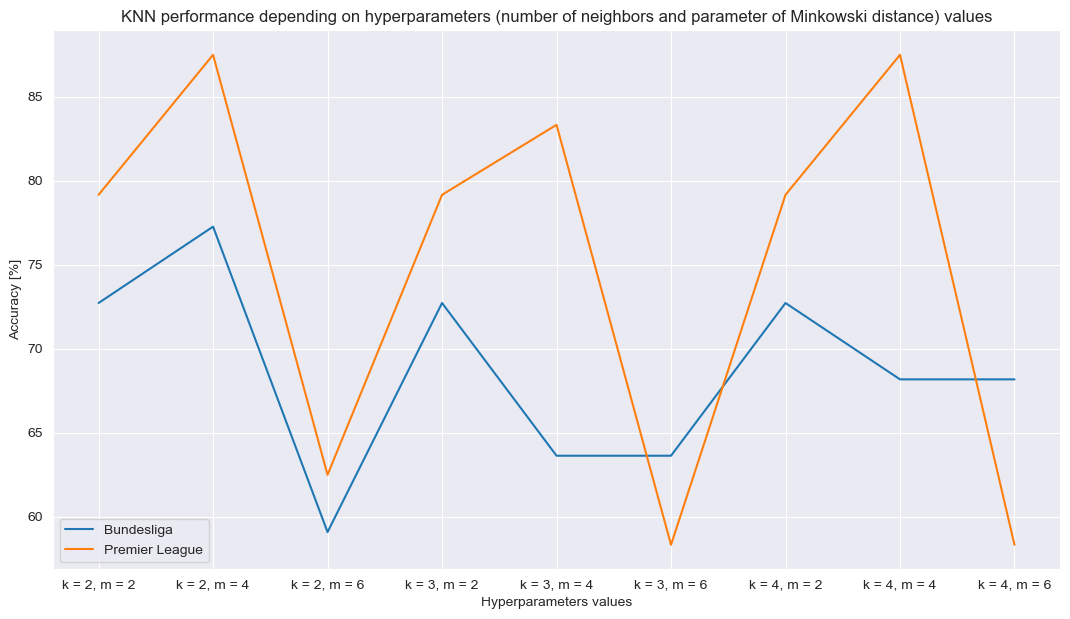

In [584]:
complex_performance = {}
plt.figure(figsize=(13,7))
performance_b = {}
performance_pl = {}
for k in (2, 3, 4):
    for m in (2, 4, 6):
        performance_b["k = "+str(k)+", m = "+str(m)] = KNN.test(training_data_scratch_bundesliga, test_data_scratch_bundesliga, k, m, "xG_level")
        performance_pl["k = "+str(k)+", m = "+str(m)] = KNN.test(training_data_scratch_pl, test_data_scratch_pl, k, m, "xG_level")
ax = sns.lineplot(x=list(performance_b.keys()), y=list(performance_b.values()), label="Bundesliga")
sns.lineplot(x=list(performance_pl.keys()), y=list(performance_pl.values()), label="Premier League")
ax.set(xlabel = "Hyperparameters values", ylabel = "Accuracy [%]", title = "KNN performance depending on hyperparameters (number of neighbors and parameter of Minkowski distance) values")
plt.show()
b_val = list(performance_b.values())
pl_val = list(performance_pl.values())
b_val.extend(pl_val)
complex_performance["KNN"] = {"B": np.mean(b_val), "PL": np.mean(pl_val)}

KNN results are definitely better for Premier League data. What is common - maximal accuracy is always obtained using m = 4 (that is input for Minkowski distance). Appropriate number of neighbors is equal to 2 or 4. Models achieve very high level of accuracy (maximal one is equal to 87.5).

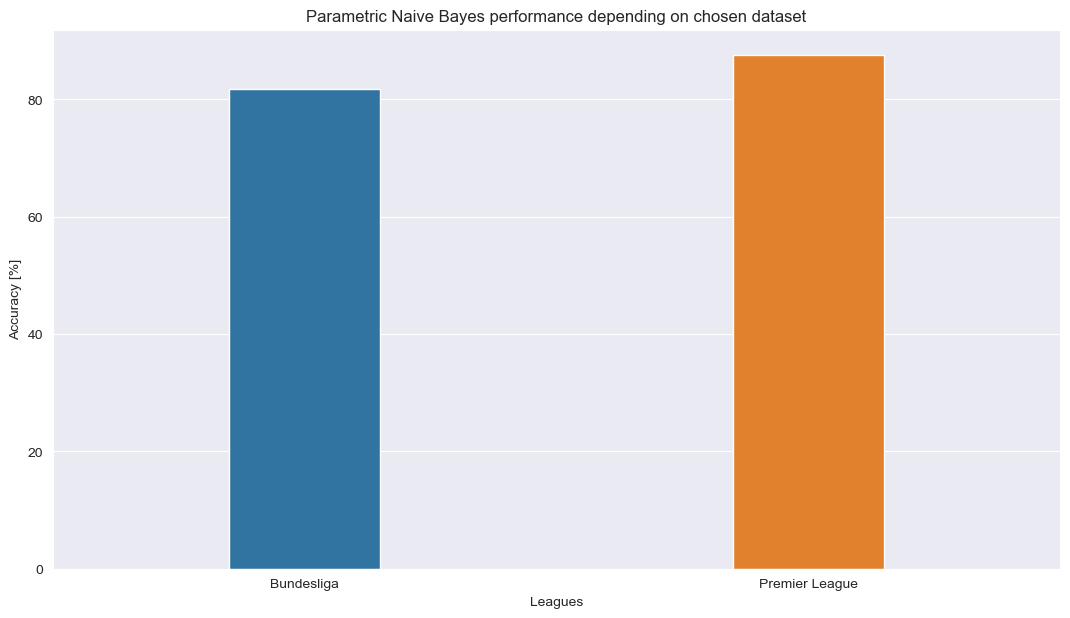

In [585]:
plt.figure(figsize=(13,7))
performance = {}
performance["Bundesliga"] = BayesNormal.execute(training_data_scratch_bundesliga, "xG_level", test_data_scratch_bundesliga)
performance["Premier League"] = BayesNormal.execute(training_data_scratch_pl, "xG_level", test_data_scratch_pl)
ax = sns.barplot(x=list(performance.keys()), y=list(performance.values()), width=0.3)
ax.set(xlabel = "Leagues", ylabel = "Accuracy [%]", title = "Parametric Naive Bayes performance depending on chosen dataset")
plt.show()
complex_performance["Par. Naive Bayes"] = {"B":performance["Bundesliga"], "PL":performance["Premier League"]}

Parametric Naive Bayes reaches for Premier League 87.5% and only slightly less for Bundesliga. 

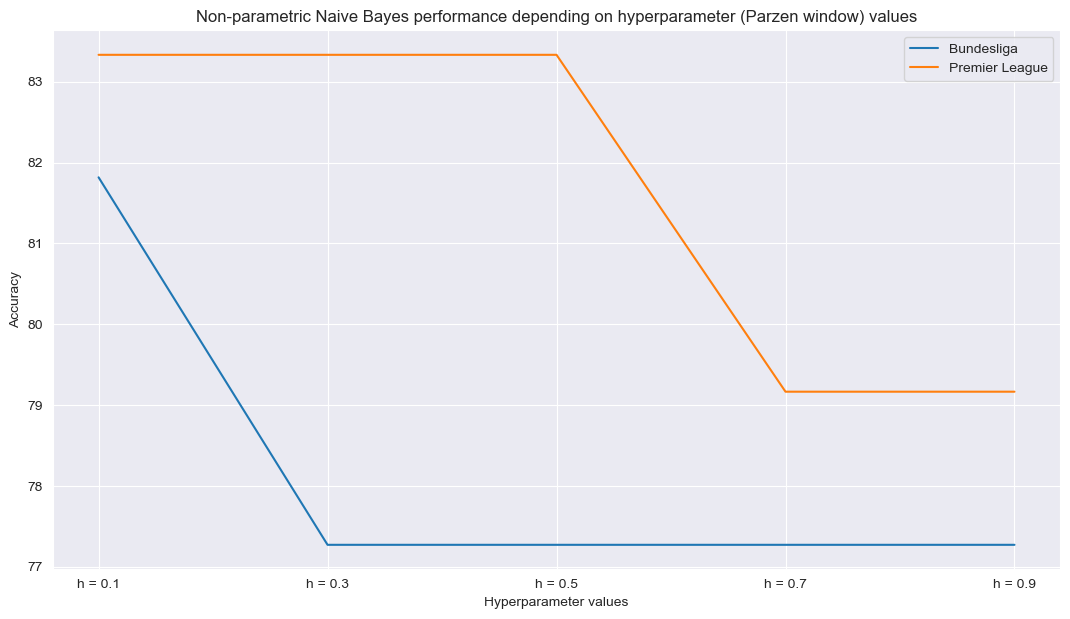

In [586]:
plt.figure(figsize=(13,7))
performance_b = {}
performance_pl = {}
for h in np.arange(0.1, 1, 0.2):
        performance_b["h = "+str(round(h,1))] = BayesParzen.execute(training_data_scratch_bundesliga, "xG_level", test_data_scratch_bundesliga, round(h, 1))
        performance_pl["h = "+str(round(h,1))] = BayesParzen.execute(training_data_scratch_pl, "xG_level", test_data_scratch_pl, round(h, 1))
ax = sns.lineplot(x=list(performance_b.keys()), y=list(performance_b.values()), label="Bundesliga")
sns.lineplot(x=list(performance_pl.keys()), y=list(performance_pl.values()), label="Premier League")
ax.set(xlabel = "Hyperparameter values", ylabel = "Accuracy", title = "Non-parametric Naive Bayes performance depending on hyperparameter (Parzen window) values")
plt.show()
b_val = list(performance_b.values())
pl_val = list(performance_pl.values())
b_val.extend(pl_val)
complex_performance["Non-Par. Naive Bayes"] = {"B": np.mean(b_val), "PL":np.mean(pl_val)}

Non-parametric Naive Bayes for h (Parzen window width) less than 0.3 for Bundesliga data and less than 0.5 for Premier League data reaches best results that are lower than those from parametric Naive Bayes.

Let's now use a few CART algorithms. In the test of single decision tree, I will use GridSearch technique to select the most optimal model.

In [587]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {"max_depth":np.arange(1,7,1)}
dt = DecisionTreeClassifier()
dt_cv = GridSearchCV(dt, param_grid, cv=kf)
dt_cv.fit(X_trainb_scaled, y_trainb)
print("Best parameter: ", dt_cv.best_params_)
print("Accuracy of model: ", dt_cv.best_score_*100)
b_val = dt_cv.best_score_*100

Best parameter:  {'max_depth': 1}
Accuracy of model:  79.08496732026144


In [588]:
dt_cv.fit(X_trainpl_scaled, y_trainpl)
print("Best parameter: ", dt_cv.best_params_)
print("Accuracy of model: ", dt_cv.best_score_*100)
pl_val = [dt_cv.best_score_*100]
complex_performance["Decision Tree"] = {"B": np.mean(b_val), "PL": np.mean(pl_val)}

Best parameter:  {'max_depth': 1}
Accuracy of model:  75.0


Apparently, trees with depth equals to 1 are the best.

Let's now focus on Bagging.

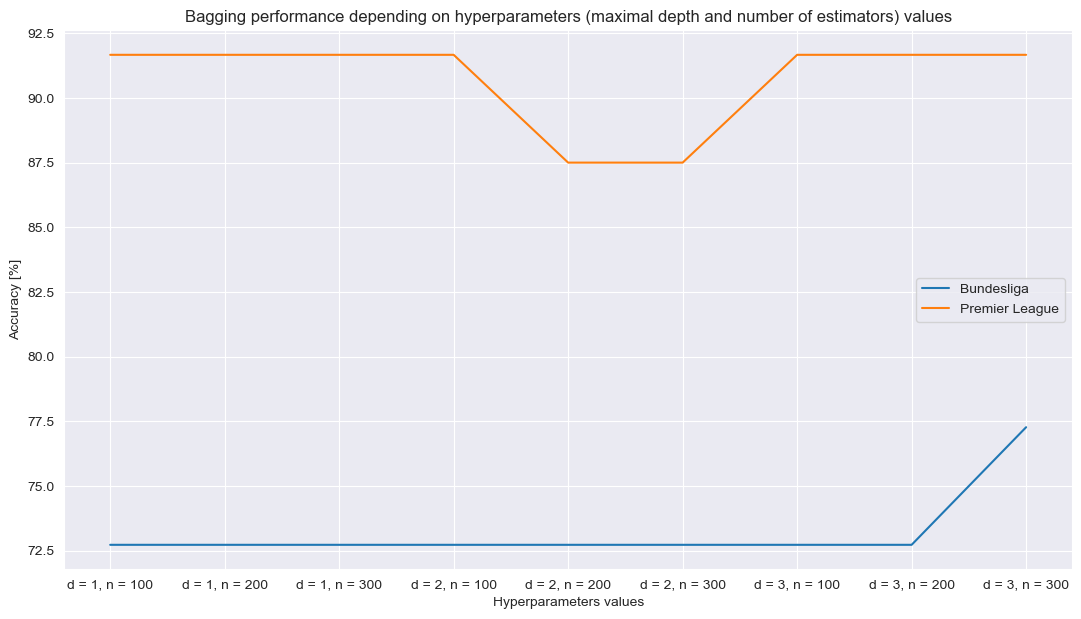

In [589]:
plt.figure(figsize=(13,7))
performance_b = {}
performance_pl = {}
for max_depth in (1, 2, 3):
    dt = DecisionTreeClassifier(max_depth = max_depth)
    for n_estimators in (100, 200, 300):
        bc_b = BaggingClassifier(estimator = dt, n_estimators = n_estimators, n_jobs = -1)
        bc_b.fit(X_trainb_scaled, y_trainb)
        y_predb = bc_b.predict(X_testb_scaled)
        performance_b["d = "+str(max_depth)+", n = "+str(n_estimators)] = accuracy_score(y_testb, y_predb) * 100
        bc_b.fit(X_trainpl_scaled, y_trainpl)
        y_predpl = bc_b.predict(X_testpl_scaled)
        performance_pl["d = "+str(max_depth)+", n = "+str(n_estimators)] = accuracy_score(y_testpl, y_predpl) * 100
ax = sns.lineplot(x=list(performance_b.keys()), y=list(performance_b.values()), label="Bundesliga")
sns.lineplot(x=list(performance_pl.keys()), y=list(performance_pl.values()), label="Premier League")
ax.set(xlabel = "Hyperparameters values", ylabel = "Accuracy [%]", title = "Bagging performance depending on hyperparameters (maximal depth and number of estimators) values")
plt.show()
b_val = list(performance_b.values())
pl_val = list(performance_pl.values())
complex_performance["Bagging"] = {"B": np.mean(b_val), "PL": np.mean(pl_val)}

Surprisingly, there is huge difference between performance of models in terms of used datasets. While results from Premier League are outstanding in every possible configuration of parameters, model based on Bundesliga data presents the same low results (comparing to the Premier League it is 20% decrease in accuracy quality).

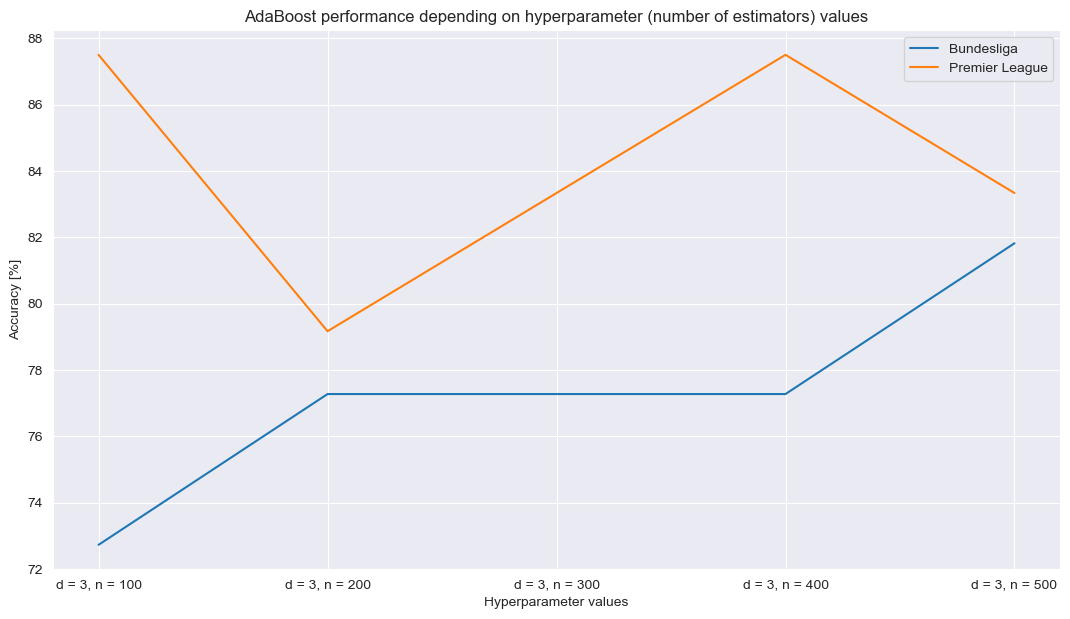

In [590]:
plt.figure(figsize=(13,7))
performance_b = {}
performance_pl = {}
dt = DecisionTreeClassifier(max_depth = max_depth)
for n_estimators in (100, 200, 300, 400, 500):
    adb_clf = AdaBoostClassifier(estimator = dt, n_estimators = n_estimators)
    adb_clf.fit(X_trainb_scaled, y_trainb)
    y_predb = adb_clf.predict(X_testb_scaled)
    performance_b["d = "+str(max_depth)+", n = "+str(n_estimators)] = accuracy_score(y_testb, y_predb) * 100
    adb_clf.fit(X_trainpl_scaled, y_trainpl)
    y_predpl = adb_clf.predict(X_testpl_scaled)
    performance_pl["d = "+str(max_depth)+", n = "+str(n_estimators)] = accuracy_score(y_testpl, y_predpl) * 100
ax = sns.lineplot(x=list(performance_b.keys()), y=list(performance_b.values()), label="Bundesliga")
sns.lineplot(x=list(performance_pl.keys()), y=list(performance_pl.values()), label="Premier League")
ax.set(xlabel = "Hyperparameter values", ylabel = "Accuracy [%]", title = "AdaBoost performance depending on hyperparameter (number of estimators) values")
plt.show()
b_val = list(performance_b.values())
pl_val = list(performance_pl.values())
complex_performance["AdaBoost"] = {"B": np.mean(b_val), "PL": np.mean(pl_val)}

Again, Premier League dataset enables model to achieve better accuracies but not that much in AdaBoost case. Here we achieve around 80% accuracy.

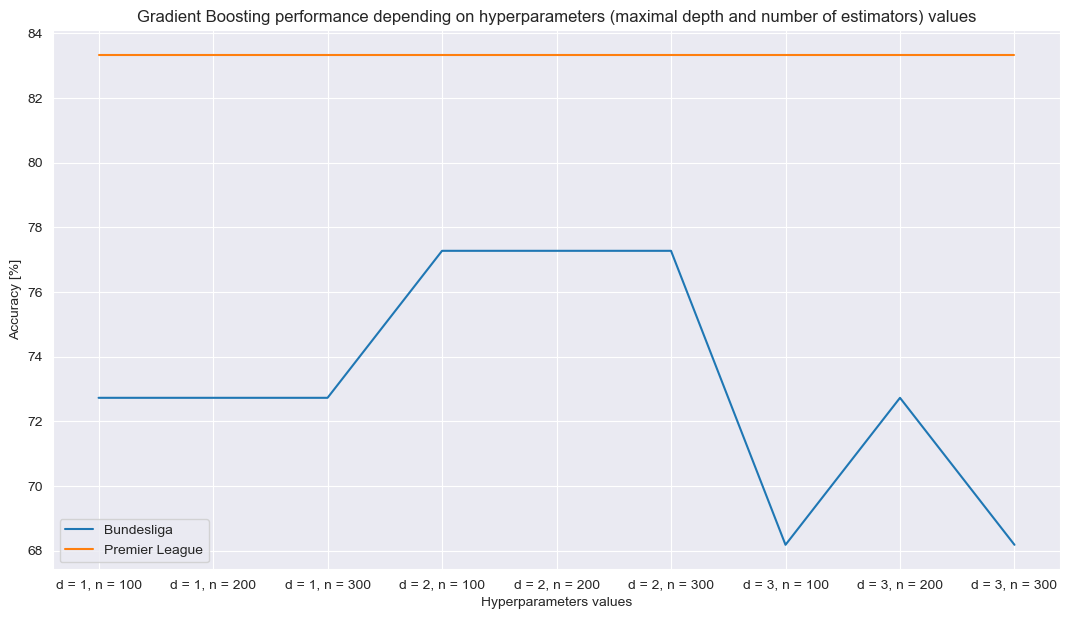

In [591]:
plt.figure(figsize=(13,7))
performance_b = {}
performance_pl = {}
for max_depth in (1, 2, 3):
    for n_estimators in (100, 200, 300):
        gbt = GradientBoostingClassifier(n_estimators = n_estimators, max_depth=max_depth)
        gbt.fit(X_trainb_scaled, y_trainb)
        y_predb = gbt.predict(X_testb_scaled)
        performance_b["d = "+str(max_depth)+", n = "+str(n_estimators)] = accuracy_score(y_testb, y_predb) * 100
        gbt.fit(X_trainpl_scaled, y_trainpl)
        y_predb = gbt.predict(X_testpl_scaled)
        performance_pl["d = "+str(max_depth)+", n = "+str(n_estimators)] = accuracy_score(y_testpl, y_predpl) * 100
ax = sns.lineplot(x=list(performance_b.keys()), y=list(performance_b.values()), label="Bundesliga")
sns.lineplot(x=list(performance_pl.keys()), y=list(performance_pl.values()), label="Premier League")
ax.set(xlabel = "Hyperparameters values", ylabel = "Accuracy [%]", title = "Gradient Boosting performance depending on hyperparameters (maximal depth and number of estimators) values")
plt.show()
b_val = list(performance_b.values())
pl_val = list(performance_pl.values())
complex_performance["Gradient Boosting"] = {"B": np.mean(b_val), "PL": np.mean(pl_val)}

Gradient Boosting results in 10% difference between datasets. Model based on Premier League dataset is completely indifferent to changing hyperparameters values. Bundesliga model is more variable, best results are obtained using maximal depth of 2.

Now, it's time to end this analysis with some neural networking.

First, to get approriate results from binary classification, we need to change categorical variable with values 'lower' and 'higher' to binary '0' and '1' values.

In [592]:
y_trainb["xG_level"] = y_trainb["xG_level"].map({"lower":0, "higher":1})
y_trainb = y_trainb.reset_index().drop("index", axis=1)
y_trainpl["xG_level"] = y_trainpl["xG_level"].map({"lower":0, "higher":1})
y_trainpl = y_trainpl.reset_index().drop("index", axis=1)

Then we can construct first network. 

In [593]:
model = Sequential()
model.add(Dense(100, activation='softmax', input_shape=(3,)))
model.add(Dense(100, activation='softmax'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_trainb_scaled, y_trainb)

b_val = model.evaluate(X_trainb_scaled, y_trainb)[-1] * 100

3/3 [==============================] - 2s 2ms/step - loss: 5.9605e-08 - accuracy: 0.5000


I constructed network with two hidden layers with 100 nodes in each. Using softmax activation function, adam optimizer and categorical cross entropy for loss function lets me obtain 50% accuracy.

In [594]:
modelpl = Sequential()
modelpl.add(Dense(200, activation='softmax', input_shape=(3,)))
modelpl.add(Dense(200, activation='softmax'))
modelpl.add(Dense(200, activation='softmax'))
modelpl.add(Dense(1))

modelpl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelpl.fit(X_trainpl_scaled, y_trainpl)

pl_val = modelpl.evaluate(X_trainpl_scaled, y_trainpl)[-1] * 100
complex_performance["Neural Network"] = {"B": b_val, "PL": pl_val}

3/3 [==============================] - 2s 3ms/step - loss: 5.9605e-08 - accuracy: 0.5000


Second network, with three hidden layers and 200 nodes in each turns out to return same accuracy.

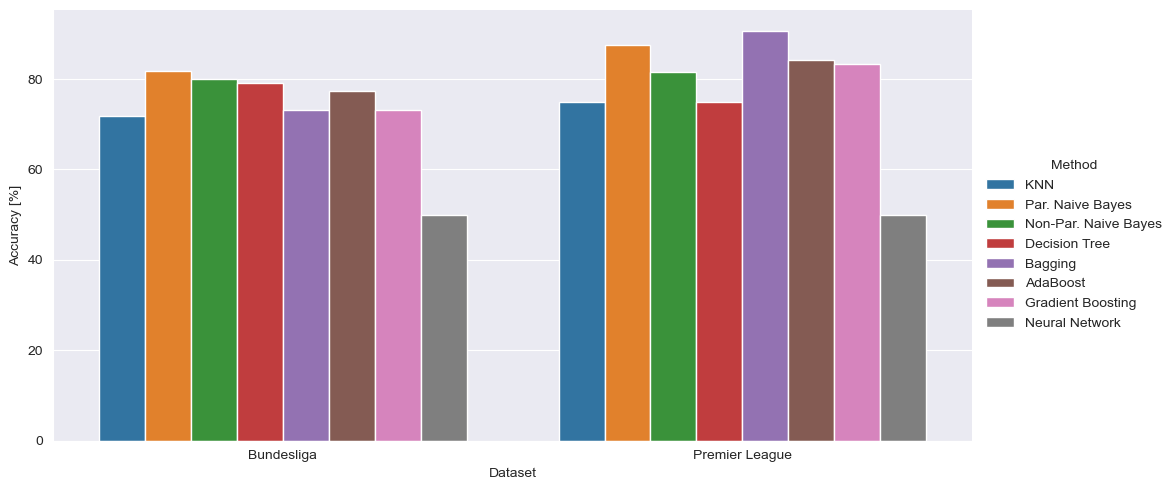

In [595]:
results = pd.DataFrame(complex_performance).reset_index()
results["index"] = pd.Series(["Bundesliga", "Premier League"])
results = pd.melt(results, id_vars = "index", var_name = "Method", value_name = "Accuracy [%]").rename(
    {"index":"Dataset"}, axis=1)
sns.catplot(x='Dataset', y='Accuracy [%]', hue='Method', data=results, kind='bar', aspect=2)
plt.show()

Final results tell us that - apart from neural network - every method is less or more efficient in terms of correct predictions, they reach 70-80% of accuracy. Bundesliga dataset somehow causes worse predictions than English one. Nevertheless, the best common score was achieved by basic parametric Naive Bayes algorithm. Bagging is best method for Premier League dataset but is outrun by many other methods in Bundesliga case. Non-parametric Naive Bayes and AdaBoost have decent outcomes as well.

The above analysis indicates that one may estimate xG level using statistics that relates to midfield and defense players. One could say that creating chances and scoring goals is the effect of collective effort of the entire team. Strikers without quality defenders who are able to eliminate the danger and midfielders whose one good pass can make a difference are - in the long run - useless.
